In [224]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d


In [71]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as cable_capacity, cmlcc.merge_cost as cable_cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [72]:
cable_coor[cable_coor['cable_length'].isna() == True]

Empty DataFrame
Columns: [geometry, cable_id, cable_name, cable_length, cable_capacity, cable_cost]
Index: []

In [73]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')
index_cable_capacity = list(cable_coor.columns).index('cable_capacity')
index_cable_cost = list(cable_coor.columns).index('cable_cost')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]
    cable_capacity = cable_coor.iloc[row,index_cable_capacity]
    cable_cost = cable_coor.iloc[row,index_cable_cost]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length, 'cable_capacity': cable_capacity,'cable_cost': cable_cost}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_21721/2595705227.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


lon1       lat1            cable_id  cable_length  \
0       -0.134426  50.828479  crosschannel-fibre         149.0   
1        0.000074  50.597677  crosschannel-fibre         149.0   
2        0.450074  50.022920  crosschannel-fibre         149.0   
3        0.797774  49.877307  crosschannel-fibre         149.0   
4       -0.204316   5.558286               glo-1        9800.0   
...           ...        ...                 ...           ...   
11075  101.250003   2.425987  damai-cable-system         575.0   
11076  101.758252   2.143087  damai-cable-system         575.0   
11077  101.870752   1.976445  damai-cable-system         575.0   
11078  101.728127   1.805588  damai-cable-system         575.0   
11079  101.447662   1.665523  damai-cable-system         575.0   

       cable_capacity  cable_cost        lon2       lat2  
0         2400.000000       3.875         NaN        NaN  
1         2400.000000       3.875   -0.134426  50.828479  
2         2400.000000       3.875    0.000074  50.597677  
3         2400.000000       3.875    0.450074  50.022920  
4            2.500000     260.000         NaN        NaN  
...               ...         ...         ...        ...  
11075       44.384991      14.375  100.575003   2.705081  
11076       44.384991      14.375  101.250003   2.425987  
11077       44.384991      14.375  101.758252   2.143087  
11078       44.384991      14.375  101.870752   1.976445  
11079       44.384991      14.375  101.728127   1.805588  

[11080 rows x 8 columns]

In [74]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [75]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

In [76]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])

gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [77]:
gdf[gdf['cable_length'].isna()==True]

Empty DataFrame
Columns: [lon1, lat1, cable_id, cable_length, cable_capacity, cable_cost, lon2, lat2, fr_point, to_point, fr_id, to_id, distance_from_previous, total_distance, length_from_previous]
Index: []

In [78]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [79]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/cable_distance.csv")

<AxesSubplot:>

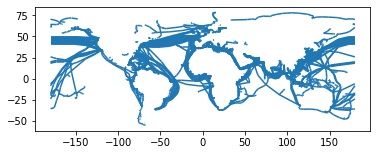

In [80]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot()

In [81]:
gdf = gdf.reset_index( )


In [82]:
gdf.sample(5)

index        lon1       lat1                      cable_id  \
6600   7511  120.149989  -6.467628                          echo   
580     644 -152.099818  59.565883  kodiak-kenai-fiber-link-kkfl   
671     749 -154.647377  59.653599                      terra-sw   
4376   5003  106.833399  -6.128965                link-3-phase-2   
5276   6033  130.499982  29.540508                       eac-c2c   

      cable_length  cable_capacity  cable_cost        lon2       lat2  \
6600   17184.00000      144.000000      255.30  123.749987  -6.467628   
580      966.00000        0.010000       30.00 -152.324818  59.508849   
671      823.83488        5.911401       53.38 -154.392007  59.697803   
4376     342.00000        0.787308       41.33  106.987498  -5.273944   
5276   36500.00000       30.000000      850.00  128.249983  30.708140   

                         fr_point                     to_point       fr_id  \
6600   POINT (120.14999 -6.46763)   POINT (123.74999 -6.46763)  11368236.0   
580   POINT (-152.09982 59.56588)  POINT (-152.32482 59.50885)  -9253394.0   
671   POINT (-154.64738 59.65360)  POINT (-154.39201 59.69780)  -9499378.0   
4376   POINT (106.83340 -6.12896)   POINT (106.98750 -5.27394)  10070444.0   
5276   POINT (130.49998 29.54051)   POINT (128.24998 30.70814)  16004049.0   

           to_id  distance_from_previous  total_distance  \
6600  11728236.0                3.599997      166.452986   
580   -9281597.0                0.232116       12.707132   
671   -9469421.0                0.259167        7.467958   
4376  10171356.0                0.868796        3.827504   
5276  15895812.0                2.534928      309.685885   

      length_from_previous                                               line  \
6600            371.650624  LINESTRING (120.14998911996437 -6.467627592690...   
580              17.645538  LINESTRING (-152.09981801512194 59.56588346342...   
671              28.590285  LINESTRING (-154.64737685086388 59.65359910967...   
4376             77.629777  LINESTRING (106.83339855415792 -6.128964849210...   
5276            298.770017  LINESTRING (130.49998178852834 29.540507745394...   

                                               geometry  
6600  LINESTRING (120.14999 -6.46763, 123.74999 -6.4...  
580   LINESTRING (-152.09982 59.56588, -152.32482 59...  
671   LINESTRING (-154.64738 59.65360, -154.39201 59...  
4376  LINESTRING (106.83340 -6.12896, 106.98750 -5.2...  
5276  LINESTRING (130.49998 29.54051, 128.24998 30.7...

In [83]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous'], create_using=nx.Graph)


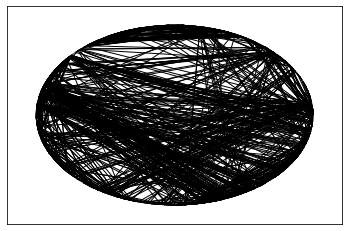

In [84]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [85]:
nx.degree_centrality(G)

{5047299.0: 0.00021422450728363326,
 5059775.0: 0.00010711225364181663,
 5067508.0: 0.00010711225364181663,
 282991.0: 0.00021422450728363326,
 535397.0: 0.0006426735218508998,
 170619.0: 0.0003213367609254499,
 4430808.0: 0.00021422450728363326,
 4628380.0: 0.000856898029134533,
 4208301.0: 0.00021422450728363326,
 3880431.0: 0.00021422450728363326,
 2965160.0: 0.00021422450728363326,
 2529840.0: 0.00021422450728363326,
 2228574.0: 0.00021422450728363326,
 2036479.0: 0.00021422450728363326,
 1752613.0: 0.00021422450728363326,
 1466113.0: 0.00021422450728363326,
 1233938.0: 0.00021422450728363326,
 533474.0: 0.00021422450728363326,
 105271.0: 0.00021422450728363326,
 -409876.0: 0.00021422450728363326,
 -716426.0: 0.00021422450728363326,
 -891421.0: 0.00021422450728363326,
 -888501.0: 0.00021422450728363326,
 -888169.0: 0.00021422450728363326,
 -168169.0: 0.00021422450728363326,
 484188.0: 0.00021422450728363326,
 562920.0: 0.00021422450728363326,
 686498.0: 0.00021422450728363326,
 986

In [86]:
# nx.current_flow_closeness_centrality(G,weight='length_from_previous')

In [87]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [88]:
for x in (nx.connected_components(G)):
    print(len(x))

3
6724
287
9
4
466
7
7
220
10
10
4
3
51
7
4
32
9
88
6
33
8
23
3
42
17
28
9
23
9
3
3
5
9
21
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
9
5
4
4
21
4
14
18
4
6
4
7
16
13
4
9
4
16
6
3
9
4
8
6
38
3
3
3
10
4
38
10
3
3
14
6
4
5
4
5
8
4
4
3
3
130
5
3
15
4
4
4
4
52
3
3
5
4
11
4
5
4
5
3
10
4
3
6
3
6
4
3
3
7
7
3
10
10
4
44
4
5
7
35
6
6
3
4
4
4
7
5
3
4
4
4
18
7
9
8
4
5
4
3
4
3
6
7
9
7
7
6
12
4
5
3
13
12
3
14
10
5
18
4
4
3
5
5
4


## Centrality

In [89]:
# getPath(max(nx.connected_components(G), key=len),gdf).plot()
raw_centrality = gdf[gdf['fr_id'].isin(max(nx.connected_components(G), key=len))]


In [90]:
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G))
raw_centrality.to_csv('/Users/dijiongyuequ/Downloads/cable_centrality_length.csv')


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [91]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    country_centrality = pd.read_sql("select sum(centrality) as country_centrality, CountryName, CapitalLongitude as capital_lon, CapitalLatitude as capital_lat, CountryCode, ContinentName from cable_centrality_length join landing_points lp on round(lon1,3) = round(landingPoint_longitude,3) and round(lat1,3) = round(landingPoint_latitude,3) left join world_countries wc on lp.landingPoint_country=wc.name left join Country_capital cc on wc.code=cc.CountryCode where CapitalName is not null group by CountryCode order by country_centrality desc",con=con)
country_centrality.head(10)

country_centrality           CountryName  capital_lon  capital_lat  \
0            0.463484                 India    77.200000    28.600000   
1            0.432545             Singapore   103.850000     1.283333   
2            0.369627                 Japan   139.750000    35.683333   
3            0.228916          Saudi Arabia    46.700000    24.650000   
4            0.216421                Brazil   -47.916667   -15.783333   
5            0.194556         United States   -77.000000    38.883333   
6            0.190540                France     2.333333    48.866667   
7            0.162576             Indonesia   106.816667    -6.166667   
8            0.156180  United Arab Emirates    54.366667    24.466667   
9            0.089395              Pakistan    73.050000    33.683333   

  CountryCode    ContinentName  
0          IN             Asia  
1          SG             Asia  
2          JP             Asia  
3          SA             Asia  
4          BR    South America  
5          US  Central America  
6          FR           Europe  
7          ID             Asia  
8          AE             Asia  
9          PK             Asia

In [92]:
world_map = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
country_centrality["country_centrality"]=country_centrality["country_centrality"]*100
lon=country_centrality["capital_lon"]
lat=country_centrality["capital_lat"]
num=country_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality["country_centrality"][i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [93]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_centrality = pd.read_sql("select landingPoint_name,landingPoint_id,landingPoint_longitude,landingPoint_latitude, sum(centrality)as country_centrality from cable_centrality_length join landing_points lp on round(lon1,3) = round(landingPoint_longitude,3) and round(lat1,3) = round(landingPoint_latitude,3) group by landingPoint_id order by country_centrality desc",con=con)
landingPoint_centrality.head(10)


landingPoint_name                landingPoint_id  \
0                   Mumbai, India                   mumbai-india   
1                    Shima, Japan                    shima-japan   
2            Jeddah, Saudi Arabia            jeddah-saudi-arabia   
3               Marseille, France               marseille-france   
4         Changi North, Singapore         changi-north-singapore   
5                 Tuas, Singapore                 tuas-singapore   
6  Fujairah, United Arab Emirates  fujairah-united-arab-emirates   
7               Fortaleza, Brazil               fortaleza-brazil   
8         Piti, GU, United States          piti-gu-united-states   
9         Changi South, Singapore         changi-south-singapore   

   landingPoint_longitude  landingPoint_latitude  country_centrality  
0               72.875866              19.076080            0.428380  
1              136.874281              34.336890            0.252863  
2               39.182863              21.481547            0.208835  
3                5.372507              43.293579            0.189499  
4              103.987012               1.389045            0.171352  
5              103.646210               1.338646            0.162427  
6               56.333726              25.121693            0.154693  
7              -38.542965              -3.718834            0.148743  
8              144.694742              13.464655            0.111260  
9              103.987012               1.389045            0.095196

In [94]:
world_map = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2.5)
landingPoint_centrality["country_centrality"]=landingPoint_centrality["country_centrality"]*100
lon=landingPoint_centrality["landingPoint_longitude"]
lat=landingPoint_centrality["landingPoint_latitude"]
num=landingPoint_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(landingPoint_centrality["country_centrality"][i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [95]:
raw_centrality['inverse_capacity'] = 1/raw_centrality['cable_capacity']
G2 = nx.from_pandas_edgelist(raw_centrality, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity', 'inverse_capacity','cable_cost'], create_using=nx.Graph)

nx.algorithms.efficiency(G2,6158154, 4629267)



/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0.029411764705882353

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

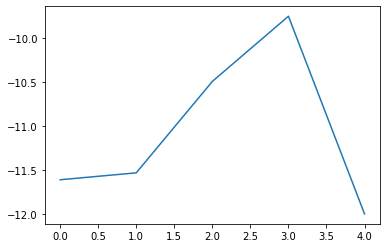

In [96]:
dict_rickClub = nx.algorithms.rich_club_coefficient(G2,normalized=False)
df_rickClub = pd.DataFrame(dict_rickClub.values(),columns=['rich_club_coefficient'])
df_rickClub['log(rich_club)'] = np.log2(df_rickClub['rich_club_coefficient'])
df_rickClub['log(rich_club)'].plot()

In [241]:
df_rickClub

rich_club_coefficient  log(rich_club)
0                0.000320      -11.611611
1                0.000337      -11.533138
2                0.000693      -10.495099
3                0.001157       -9.754967
4                0.000244      -11.999648
5                0.000000            -inf
6                0.000000            -inf
7                0.000000            -inf
8                0.000000            -inf
9                0.000000            -inf
10               0.000000            -inf
11               0.000000            -inf
12               0.000000            -inf
13               0.000000            -inf
14               0.000000            -inf
15               0.000000            -inf
16               0.000000            -inf
17               0.000000            -inf

# Betweenness centrality

In [97]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [98]:
# raw_centrality.
dict_betweennessCentrality_length = nx.algorithms.betweenness_centrality(G2,weight='length_from_previous')
df_betweennessCentrality_length = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_length.keys(), 'betCentralityValue': dict_betweennessCentrality_length.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

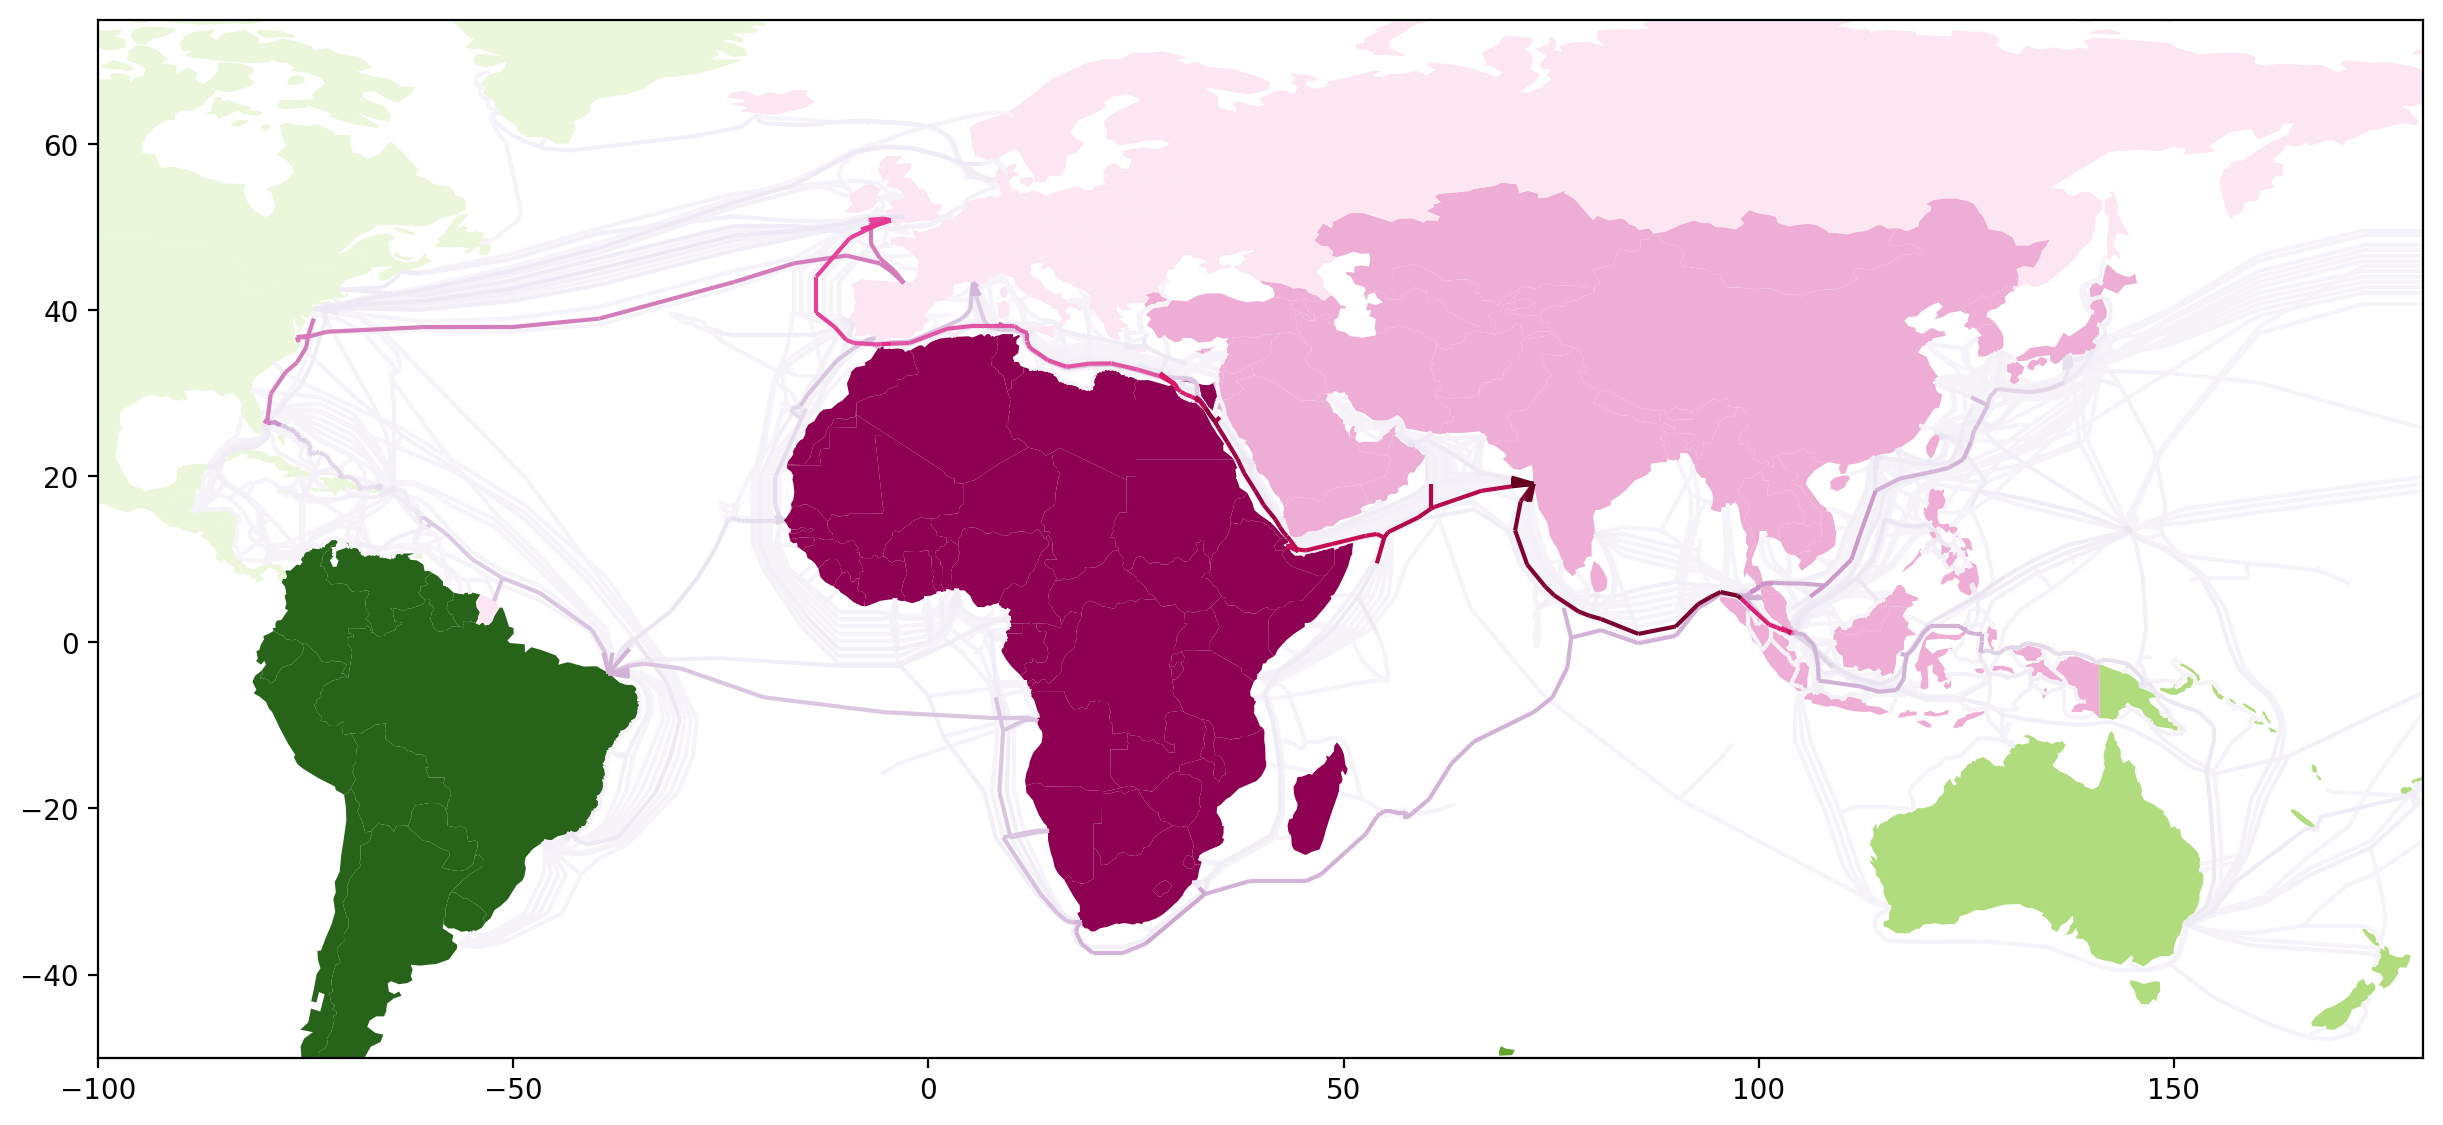

In [99]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_length, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='PuRd')
plt.xlim([-100,180])
plt.ylim([-50,75])

In [100]:
dict_betweennessCentrality_capacity = nx.algorithms.betweenness_centrality(G2,weight='cable_capacity')
df_betweennessCentrality_capacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_capacity.keys(), 'betCentralityValue': dict_betweennessCentrality_capacity.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

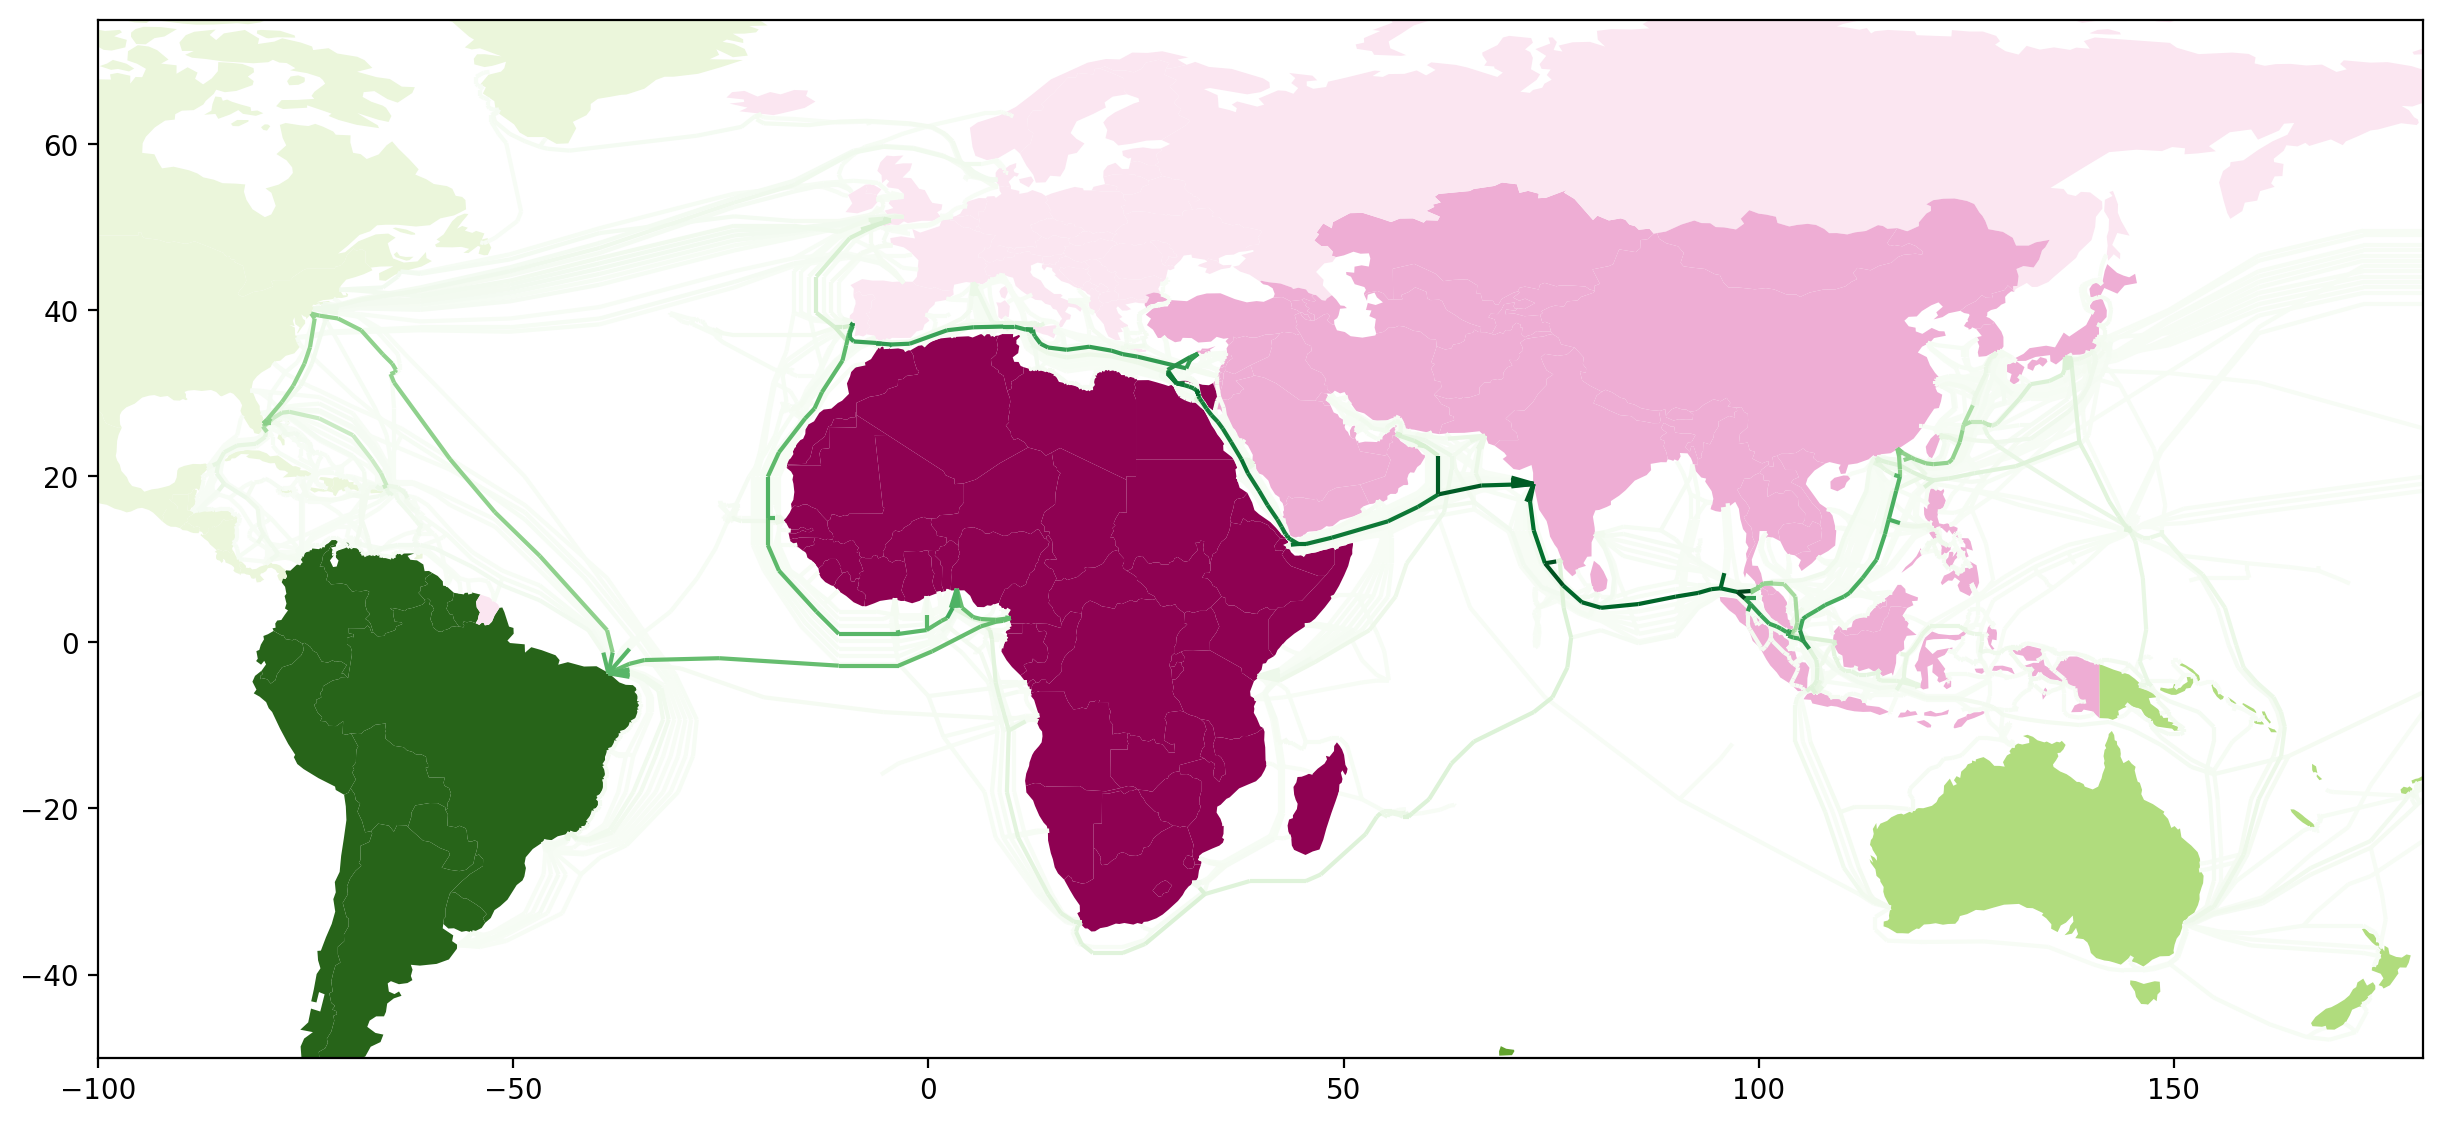

In [101]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_capacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Greens')
plt.xlim([-100,180])
plt.ylim([-50,75])



In [102]:
# raw_centrality.
dict_betweennessCentrality_cost = nx.algorithms.betweenness_centrality(G2,weight='cable_cost')
df_betweennessCentrality_cost = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_cost.keys(), 'betCentralityValue': dict_betweennessCentrality_cost.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

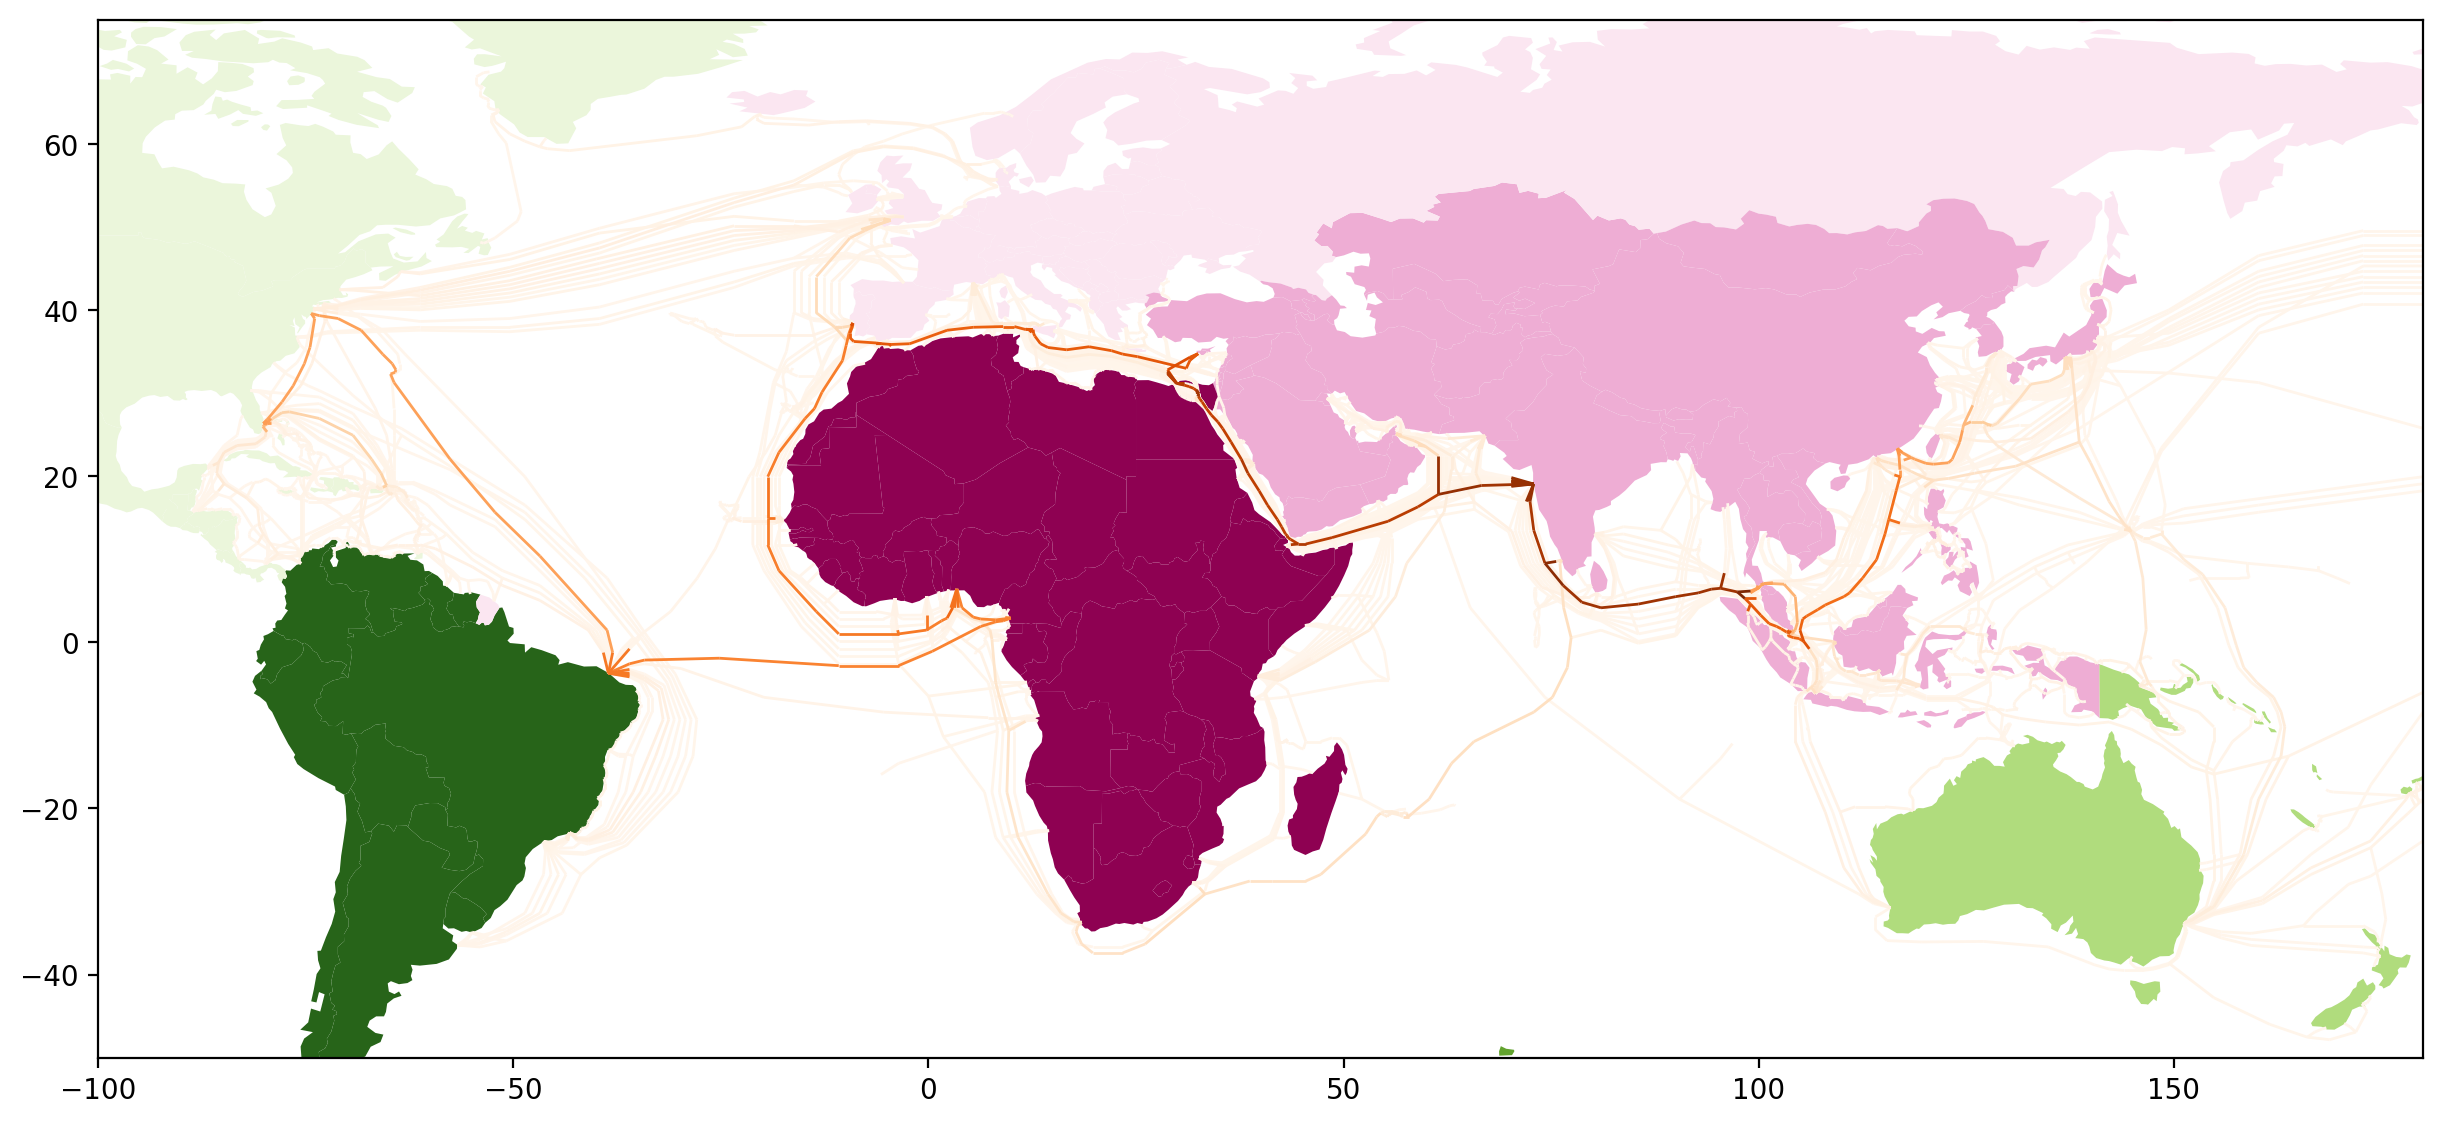

In [103]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_capacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Oranges',linewidth=1)
plt.xlim([-100,180])
plt.ylim([-50,75])


In [104]:
# raw_centrality.
dict_betweennessCentrality_incerseCapacity = nx.algorithms.betweenness_centrality(G2,weight='inverse_capacity')
df_betweennessCentrality_incerseCapacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_incerseCapacity.keys(), 'betCentralityValue': dict_betweennessCentrality_incerseCapacity.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

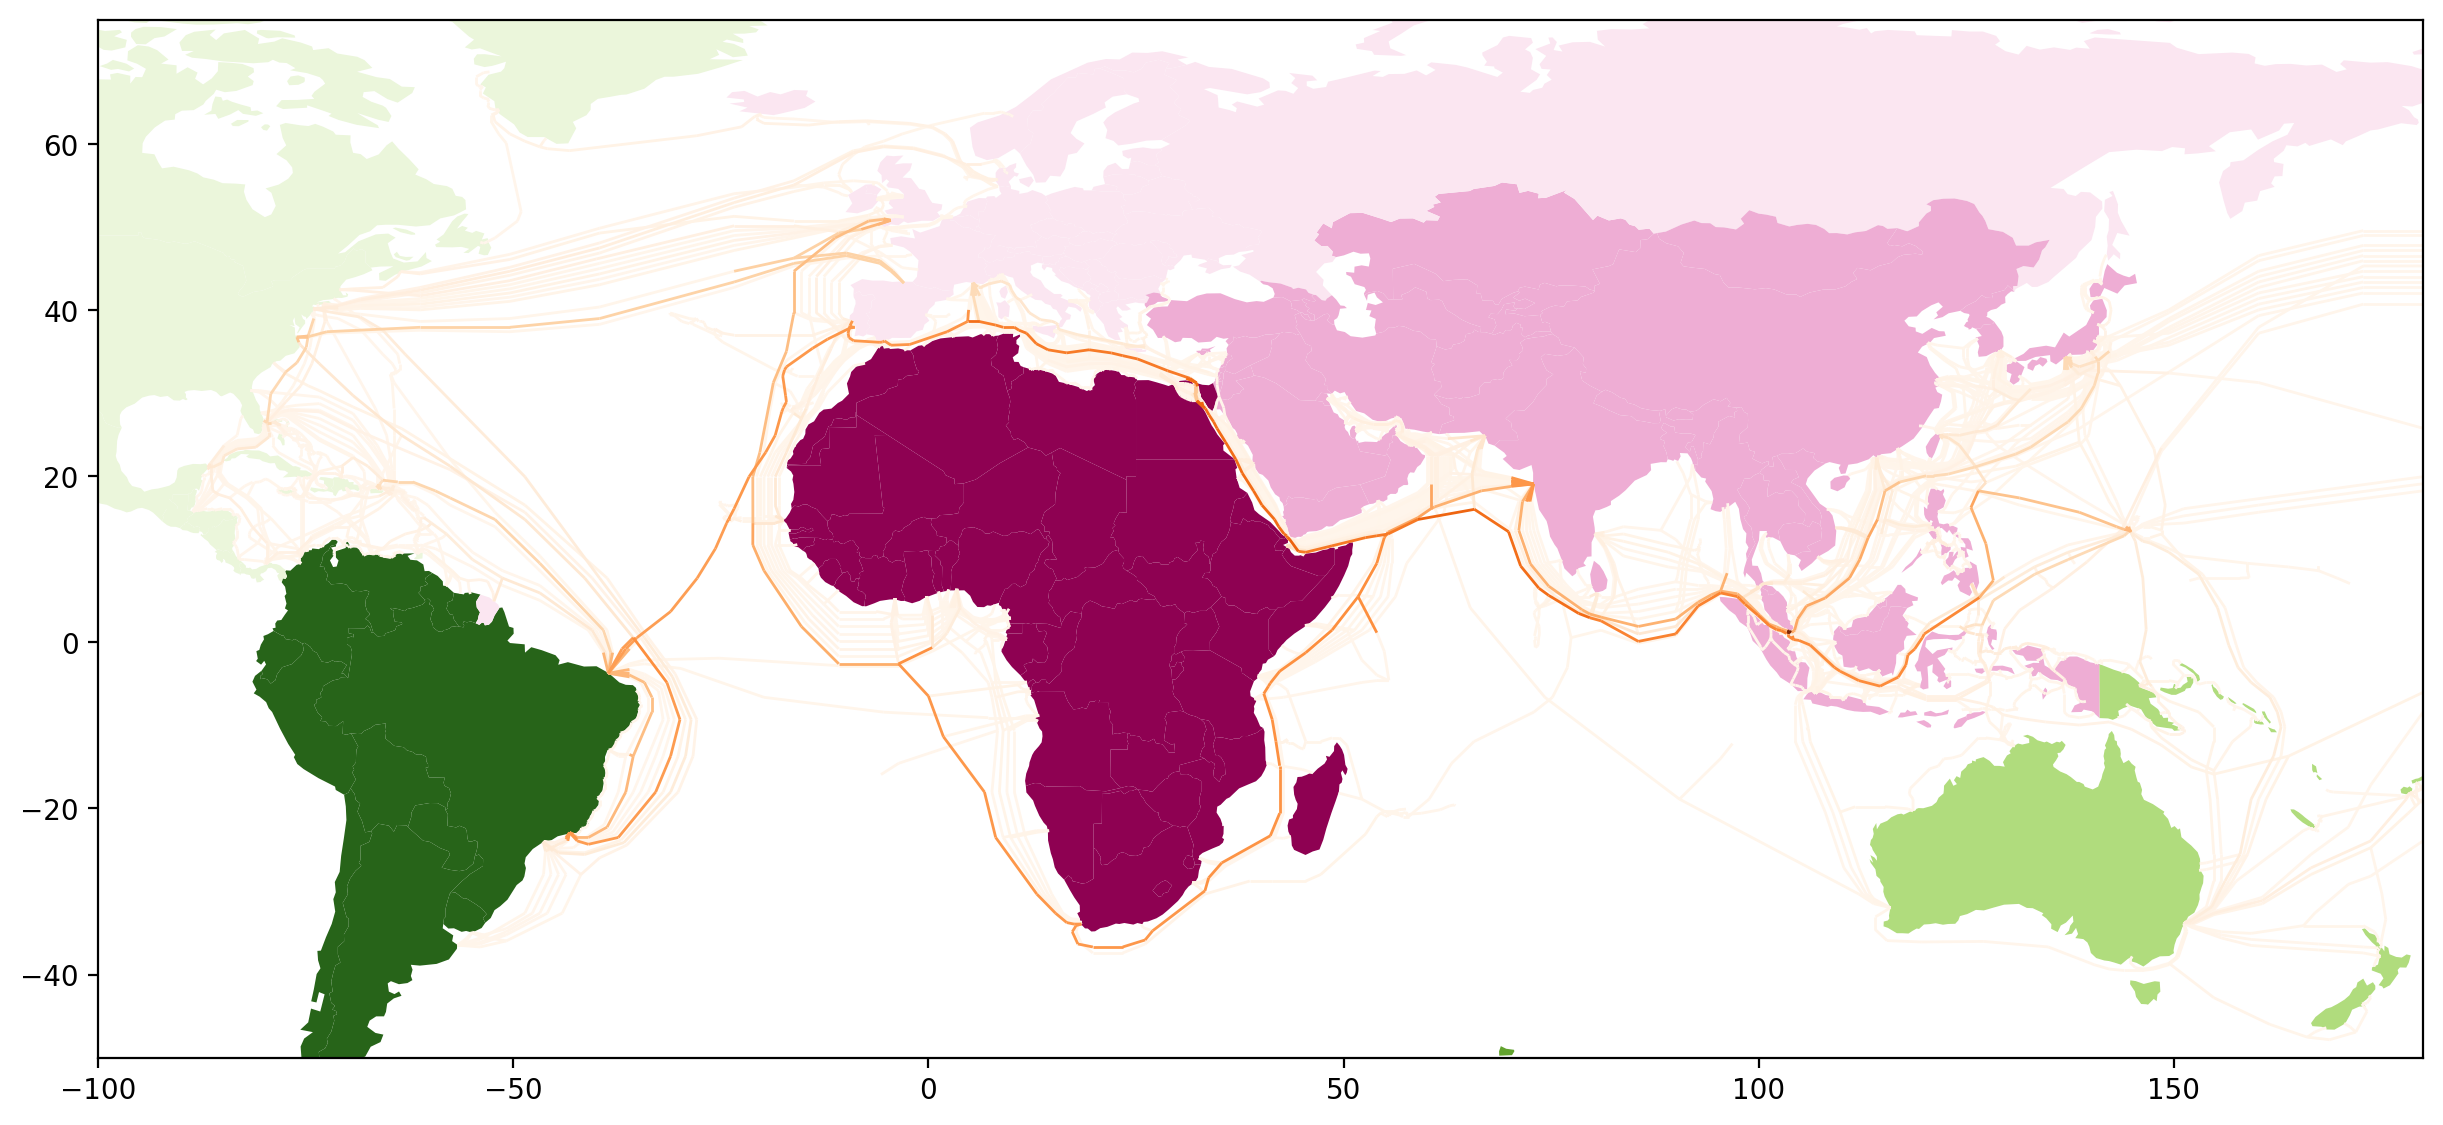

In [105]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_incerseCapacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Oranges',linewidth=1)
plt.xlim([-100,180])
plt.ylim([-50,75])


In [119]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    pacific_landingPoint = pd.read_sql("select lp.cable_id,lp.cable_name,cable_length, cmlcc.ac_cap as cable_capacity, cmlcc.ac_cost as cable_cost, landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude from landing_points lp left join cable_merge_length_capacity_cost cmlcc on lp.cable_id=cmlcc.cable_id where lp.cable_id ='tui-samoa' or lp.cable_id ='tonga-domestic-cable-extension-tdce' or lp.cable_id ='tonga-cable' or lp.cable_id ='samoa-american-samoa-sas' or lp.landingPoint_id ='alofi-niue'",con=con)
pacific_landingPoint

cable_id  \
0              samoa-american-samoa-sas   
1              samoa-american-samoa-sas   
2   tonga-domestic-cable-extension-tdce   
3   tonga-domestic-cable-extension-tdce   
4   tonga-domestic-cable-extension-tdce   
5                           tonga-cable   
6                           tonga-cable   
7                               manatua   
8                             tui-samoa   
9                             tui-samoa   
10                            tui-samoa   
11                            tui-samoa   
12                            tui-samoa   
13                            tui-samoa   

                               cable_name  cable_length  cable_capacity  \
0              Samoa-American Samoa (SAS)           250             NaN   
1              Samoa-American Samoa (SAS)           250             NaN   
2   Tonga Domestic Cable Extension (TDCE)           410            40.0   
3   Tonga Domestic Cable Extension (TDCE)           410            40.0   
4   Tonga Domestic Cable Extension (TDCE)           410            40.0   
5                             Tonga Cable           827             NaN   
6                             Tonga Cable           827             NaN   
7                                 Manatua          3634            10.0   
8                               Tui-Samoa          1693            17.6   
9                               Tui-Samoa          1693            17.6   
10                              Tui-Samoa          1693            17.6   
11                              Tui-Samoa          1693            17.6   
12                              Tui-Samoa          1693            17.6   
13                              Tui-Samoa          1693            17.6   

    cable_cost             landingPoint_id            landingPoint_name  \
0         6.25    pago-pago-american-samoa    Pago Pago, American Samoa   
1         6.25                  apia-samoa                  Apia, Samoa   
2        10.50                neiafu-tonga                Neiafu, Tonga   
3        10.50             nukualofa-tonga            Nuku'alofa, Tonga   
4        10.50                pangai-tonga                Pangai, Tonga   
5          NaN                   suva-fiji                   Suva, Fiji   
6          NaN             nukualofa-tonga            Nuku'alofa, Tonga   
7       100.00                  alofi-niue                  Alofi, Niue   
8        32.50               savusavu-fiji               Savusavu, Fiji   
9        32.50                   suva-fiji                   Suva, Fiji   
10       32.50                  apia-samoa                  Apia, Samoa   
11       32.50               tuasivi-samoa               Tuasivi, Samoa   
12       32.50     leava-wallis-and-futuna     Leava, Wallis and Futuna   
13       32.50  mata-utu-wallis-and-futuna  Mata-Utu, Wallis and Futuna   

   landingPoint_country  landingPoint_longitude  landingPoint_latitude  
0        American Samoa             -170.695713             -14.276549  
1                 Samoa             -171.766679             -13.833403  
2                 Tonga             -173.983685             -18.647685  
3                 Tonga             -175.200032             -21.133286  
4                 Tonga             -174.350261             -19.811428  
5                  Fiji              178.437448             -18.123638  
6                 Tonga             -175.200032             -21.133286  
7                  Niue             -169.916704             -19.016701  
8                  Fiji              179.349753             -16.808014  
9                  Fiji              178.437448             -18.123638  
10                Samoa             -171.766679             -13.833403  
11                Samoa             -172.178161             -13.670594  
12    Wallis and Futuna             -178.158108             -14.296838  
13    Wallis and Futuna             -176.175000             -13.282001

(31, 18)


<AxesSubplot:>

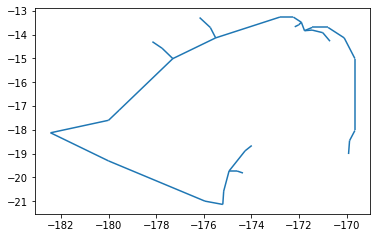

In [120]:
pacific_cable_gps = gdf[(gdf['cable_id'].isin(pacific_landingPoint['cable_id'])) & (gdf['lon1'] < -168)]
print(pacific_cable_gps.shape)
temp_gpf = gpd.GeoDataFrame([
[-182.43744782858172, -18.123638259082412, -179.999798,-19.305384,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-19.305384]])],
[-182.43744782858172, -18.123638259082412, -179.999798,-17.597999,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-17.597999]])]],columns=['lon1','lat1','lon2','lat2','geometry'],geometry='geometry')
temp_gpf['fr_id'] = round((round(temp_gpf['lon1'],5) + round(temp_gpf['lat1'],5))*100000,0)
temp_gpf['to_id'] = round((round(temp_gpf['lon2'],5) + round(temp_gpf['lat2'],5))*100000,0)
pacific_cable_gps = pacific_cable_gps.append(temp_gpf)
pacific_cable_gps.plot()

In [121]:
chinese_postman_lines = gpd.GeoDataFrame([
# [-175.20000165073517,-21.13346565929308,Point(-175.20000165073517,-21.13346565929308), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-173.98368505307081,-18.65921570866675,Point(-173.98368505307081,-18.65921570866675), -170.6957048416213,-14.276544564158712,Point(-170.6957048416213,-14.276544564158712)],
[-169.91670539347172,-19.016714981418488,Point(-169.91670539347172,-19.016714981418488), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-171.76669408292253,-13.833489255757883,Point(-171.76669408292253,-13.833489255757883), -172.17816102513325,-13.670594022635811,Point(-172.17816102513325,-13.670594022635811)],
[-178.1581082284118,-14.29683787673278,Point(-178.1581082284118,-14.29683787673278), -176.17500034981677,-13.28200057514735,Point(-176.17500034981677,-13.28200057514735)]],columns=['lon1','lat1','geometry_a', 'lon2','lat2','geometry_b'])
chinese_postman_lines['fr_id'] = round((round(chinese_postman_lines['lon1'],5) + round(chinese_postman_lines['lat1'],5))*100000,0)
chinese_postman_lines['to_id'] = round((round(chinese_postman_lines['lon2'],5) + round(chinese_postman_lines['lat2'],5))*100000,0)


<AxesSubplot:>

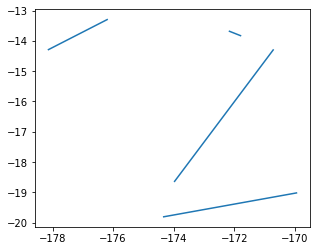

In [122]:
chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
target_gdf['fr_point'] = gpd.points_from_xy(x=target_gdf['lon1'],y=target_gdf['lat1'])
target_gdf['to_point'] = gpd.points_from_xy(x=target_gdf['lon2'],y=target_gdf['lat2'])
target_gdf['distance_from_previous'] = target_gdf['fr_point'].distance(target_gdf['to_point'])
target_gdf['length_from_previous'] = target_gdf['distance_from_previous'] * 103.3934 + 51.6973
target_gdf.plot()

In [123]:
def chinese_postman():
    chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
    target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
    return target_gdf
chinese_postman_gdf = chinese_postman()

In [124]:
pacific_cable_gps.head(5)

index        lon1       lat1 cable_id  cable_length  cable_capacity  \
630  703.0 -169.874805 -18.453814  manatua        3634.0            10.0   
631  704.0 -169.916705 -19.016715  manatua        3634.0            10.0   
632  706.0 -171.449804 -13.698987  manatua        3634.0            10.0   
633  707.0 -170.774805 -13.698987  manatua        3634.0            10.0   
634  708.0 -170.099805 -14.135775  manatua        3634.0            10.0   

     cable_cost        lon2       lat2                      fr_point  \
630       100.0 -169.649806 -18.026426  POINT (-169.87481 -18.45381)   
631       100.0 -169.874805 -18.453814  POINT (-169.91671 -19.01671)   
632       100.0 -171.766694 -13.833489  POINT (-171.44980 -13.69899)   
633       100.0 -171.449804 -13.698987  POINT (-170.77480 -13.69899)   
634       100.0 -170.774805 -13.698987  POINT (-170.09981 -14.13578)   

                         to_point       fr_id       to_id  \
630  POINT (-169.64981 -18.02643) -18832862.0 -18767624.0   
631  POINT (-169.87481 -18.45381) -18893342.0 -18832862.0   
632  POINT (-171.76669 -13.83349) -18514879.0 -18560018.0   
633  POINT (-171.44980 -13.69899) -18447379.0 -18514879.0   
634  POINT (-170.77480 -13.69899) -18423559.0 -18447379.0   

     distance_from_previous  total_distance  length_from_previous  \
630                0.482996       32.680099             53.708730   
631                0.564458       32.680099             62.767316   
632                0.344253       32.680099             38.280614   
633                0.675000       32.680099             75.059388   
634                0.803995       32.680099             89.403596   

                                                  line  \
630  LINESTRING (-169.87480542315404 -18.4538137757...   
631  LINESTRING (-169.91670539347172 -19.0167149814...   
632  LINESTRING (-171.44980430741003 -13.6989872696...   
633  LINESTRING (-170.77480478558613 -13.6989872696...   
634  LINESTRING (-170.0998052637621 -14.13577537506...   

                                              geometry  
630  LINESTRING (-169.87481 -18.45381, -169.64981 -...  
631  LINESTRING (-169.91671 -19.01671, -169.87481 -...  
632  LINESTRING (-171.44980 -13.69899, -171.76669 -...  
633  LINESTRING (-170.77480 -13.69899, -171.44980 -...  
634  LINESTRING (-170.09981 -14.13578, -170.77480 -...

In [128]:
world_basemap = gpd.read_file('/Users/dijiongyuequ/Downloads/GitHub/UCL_Dessertation/Dataset/GIS_data/123.geojson')
world_basemap

FID                               COUNTRY ISO          COUNTRYAFF  \
0      1                        American Samoa  AS       United States   
1      2  United States Minor Outlying Islands  UM       United States   
2      3                          Cook Islands  CK         New Zealand   
3      4                      French Polynesia  PF              France   
4      5                                  Niue  NU         New Zealand   
..   ...                                   ...  ..                 ...   
244  245              Northern Mariana Islands  MP       United States   
245  246                                 Palau  PW               Palau   
246  247                    Russian Federation  RU  Russian Federation   
247  248                                 Spain  ES               Spain   
248  249                              Canarias  ES               Spain   

    AFF_ISO   SHAPE_Leng   SHAPE_Area  \
0        US     0.600124     0.013720   
1        US     0.480216     0.003216   
2        NZ     0.980664     0.013073   
3        FR     3.930211     0.175332   
4        NZ     0.541413     0.021414   
..      ...          ...          ...   
244      US     0.908853     0.019927   
245      PW     1.105323     0.031136   
246      RU  1536.287150  2931.526082   
247      ES    51.724956    52.915449   
248      ES     9.491474     0.695336   

                                              geometry  
0    MULTIPOLYGON (((-170.74390 -14.37555, -170.749...  
1    MULTIPOLYGON (((-160.02114 -0.39805, -160.0281...  
2    MULTIPOLYGON (((-159.74698 -21.25667, -159.793...  
3    MULTIPOLYGON (((-149.17920 -17.87084, -149.258...  
4    MULTIPOLYGON (((-169.89389 -19.14556, -169.930...  
..                                                 ...  
244  MULTIPOLYGON (((145.73468 15.08722, 145.72830 ...  
245  MULTIPOLYGON (((134.53137 7.35444, 134.52234 7...  
246  MULTIPOLYGON (((-179.99999 68.98010, -179.9580...  
247  MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35...  
248  MULTIPOLYGON (((-17.91125 27.77374, -17.96389 ...  

[249 rows x 8 columns]

index        lon1       lat1                             cable_id  \
630    703.0 -169.874805 -18.453814                              manatua   
631    704.0 -169.916705 -19.016715                              manatua   
632    706.0 -171.449804 -13.698987                              manatua   
633    707.0 -170.774805 -13.698987                              manatua   
634    708.0 -170.099805 -14.135775                              manatua   
635    709.0 -169.649806 -15.006817                              manatua   
636    710.0 -169.649806 -18.026426                              manatua   
1034  1172.0 -171.449804 -13.808261             samoa-american-samoa-sas   
1035  1173.0 -170.999805 -13.917484             samoa-american-samoa-sas   
1036  1174.0 -170.695705 -14.276545             samoa-american-samoa-sas   
1044  1184.0 -174.599802 -19.729525  tonga-domestic-cable-extension-tdce   
1045  1185.0 -174.352142 -19.813796  tonga-domestic-cable-extension-tdce   
1046  1187.0 -174.262302 -18.880140  tonga-domestic-cable-extension-tdce   
1047  1188.0 -174.937302 -19.729525  tonga-domestic-cable-extension-tdce   
1048  1189.0 -175.162302 -20.574419  tonga-domestic-cable-extension-tdce   
1049  1190.0 -175.200002 -21.133466  tonga-domestic-cable-extension-tdce   
1050  1192.0 -175.724801 -13.698987                            tui-samoa   
1051  1193.0 -175.499801 -14.135775                            tui-samoa   
1052  1195.0 -177.749800 -14.571726                            tui-samoa   
1053  1196.0 -177.299800 -15.006817                            tui-samoa   
1056  1201.0 -171.899804 -13.480287                            tui-samoa   
1057  1202.0 -172.237304 -13.261386                            tui-samoa   
1058  1203.0 -172.799803 -13.261386                            tui-samoa   
1059  1204.0 -175.499801 -14.135775                            tui-samoa   
1060  1205.0 -177.299800 -15.006817                            tui-samoa   
1061  1206.0 -179.549799 -17.168553                            tui-samoa   
1062  1207.0 -179.999798 -17.597999                            tui-samoa   
1063  1209.0 -172.012304 -13.589662                            tui-samoa   
1064  1210.0 -172.178161 -13.670594                            tui-samoa   
1067  1215.0 -175.949801 -20.995132                          tonga-cable   
1068  1216.0 -175.200002 -21.133466                          tonga-cable   
0        NaN -182.437448 -18.123638                                  NaN   
1        NaN -182.437448 -18.123638                                  NaN   

      cable_length  cable_capacity  cable_cost        lon2       lat2  \
630         3634.0       10.000000      100.00 -169.649806 -18.026426   
631         3634.0       10.000000      100.00 -169.874805 -18.453814   
632         3634.0       10.000000      100.00 -171.766694 -13.833489   
633         3634.0       10.000000      100.00 -171.449804 -13.698987   
634         3634.0       10.000000      100.00 -170.774805 -13.698987   
635         3634.0       10.000000      100.00 -170.099805 -14.135775   
636         3634.0       10.000000      100.00 -169.649806 -15.006817   
1034         250.0        2.491475        6.25 -171.766694 -13.833489   
1035         250.0        2.491475        6.25 -171.449804 -13.808261   
1036         250.0        2.491475        6.25 -170.999805 -13.917484   
1044         410.0       40.000000       10.50 -174.937302 -19.729525   
1045         410.0       40.000000       10.50 -174.599802 -19.729525   
1046         410.0       40.000000       10.50 -173.983685 -18.659216   
1047         410.0       40.000000       10.50 -174.262302 -18.880140   
1048         410.0       40.000000       10.50 -174.937302 -19.729525   
1049         410.0       40.000000       10.50 -175.162302 -20.574419   
1050        1693.0       17.600000       32.50 -176.175000 -13.282001   
1051        1693.0       17.600000       32.50 -175.724801 -13.698987   
1052        1693.0       17.600000 

(-22.0, -12.0)

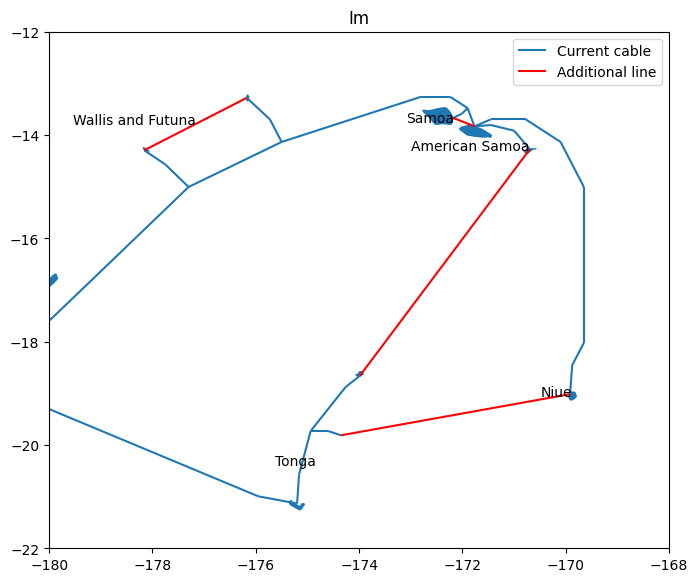

In [137]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")

world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)


pacific_cable_gps.plot(ax=ax,label = 'Current cable')
chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
plt.legend()
plt.title("Im")
plt.xlim([-180,-168])
plt.ylim([-22,-12])


In [113]:
G3 = nx.from_pandas_edgelist(pacific_cable_gps, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)

print(np.average(list(nx.algorithms.degree_centrality(G3).values())))

G4 = nx.from_pandas_edgelist(pacific_cable_gps.append(chinese_postman_gdf), 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)
print(np.average(list(nx.algorithms.degree_centrality(G4).values())))

# chinese_postman_gdf.plot()
# pacific_cable_gps.plot()
print('universally all the node is more participate into the network')

0.058823529411764705
0.0659536541889483


0.2740740740740741, 0.26595365418894834


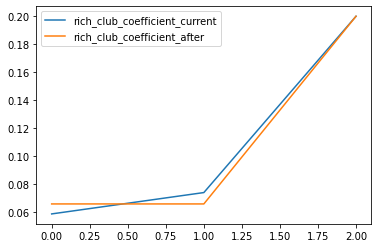

In [267]:
dict_rickClub_current = nx.algorithms.rich_club_coefficient(G3,normalized=False)
dict_rickClub_after = nx.algorithms.rich_club_coefficient(G4,normalized=False)
df_rickClub = pd.DataFrame(dict_rickClub_current.values(),columns=['rich_club_coefficient_current'])
df_rickClub['rich_club_coefficient_after'] = dict_rickClub_after.values()
df_rickClub.plot()


print(f'{sum(list(dict_rickClub_current.values())[-2:])}, {sum(list(dict_rickClub_after.values())[-2:])}')
# print(dict_rickClub_current)
# print(dict_rickClub_after)
print('The improved network is less dependent on the high degree nodes')

In [266]:
list(dict_rickClub_current.values())[-2:]

[0.07407407407407407, 0.2]

{0: 0.058823529411764705, 1: 0.07407407407407407, 2: 0.2}

In [114]:
temp = pacific_cable_gps

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G3), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G3))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [115]:
temp = pacific_cable_gps.append(chinese_postman_gdf)

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G4), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G4))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [116]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world



In [117]:

{k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}
# nx.draw_networkx_edges(G4, pos=nx.circular_layout(G4))

# for x in (nx.connected_components(G4)):
#     print(len(x))


# max(nx.connected_components(G4), key=len)

{-18560018.0: 0.16666666666666666,
 -18538009.0: 0.3333333333333333,
 -18560196.0: 1.0,
 -18584875.0: 1.0}

(-22.0, -12.0)

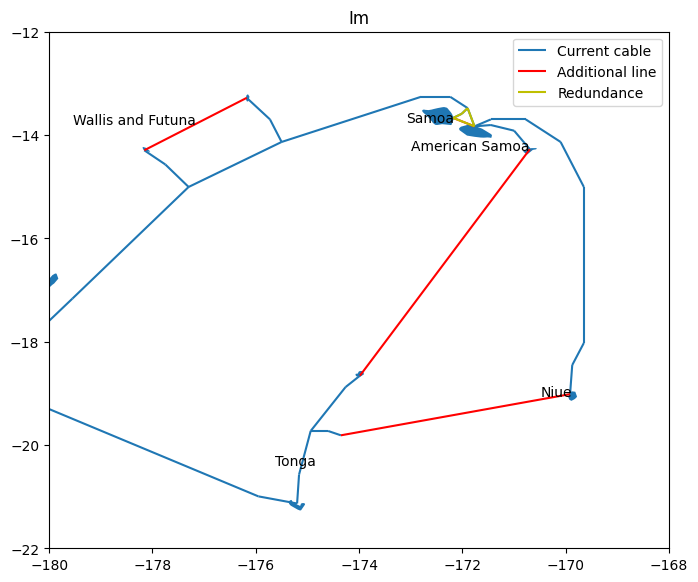

In [142]:
temp = pacific_cable_gps.append(chinese_postman_gdf)


fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")
world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)

pacific_cable_gps.plot(ax=ax,label = 'Current cable')

chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
temp[temp['fr_id'].isin({k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}.keys())].plot(ax=ax,label = 'Redundance', color='y')
plt.legend()
plt.title("Im")
plt.xlim([-180,-168])
plt.ylim([-22,-12])

In [179]:
pacific_cable_groupBy = pacific_landingPoint.groupby(['cable_id','cable_length','cable_cost'],as_index=False).agg({'cable_name':'count'})
sm.OLS(endog=pacific_cable_groupBy['cable_cost'], exog=sm.add_constant(pacific_cable_groupBy['cable_length'])).fit().summary()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cable_cost   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     78.96
Date:                Fri, 29 Apr 2022   Prob (F-statistic):             0.0124
Time:                        15:06:52   Log-Likelihood:                -12.776
No. Observations:                   4   AIC:                             29.55
Df Residuals:                       2   BIC:                             28.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.6446      6.217     -0.586      0.617     -30.393      23.104
cable_length     0.0274      0.003      8.886      0.012       0.014       0.041
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.244
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.929
Skew:                          -1.130   Prob(JB):                        0.629
Kurtosis:                       2.316   Cond. No.                     3.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [186]:
pacific_cable_groupBy

cable_id  cable_length  cable_cost  cable_name
0                              manatua          3634      100.00           1
1             samoa-american-samoa-sas           250        6.25           2
2  tonga-domestic-cable-extension-tdce           410       10.50           3
3                            tui-samoa          1693       32.50           6

Text(0.5, 1.0, 'Estimation of cable cost')

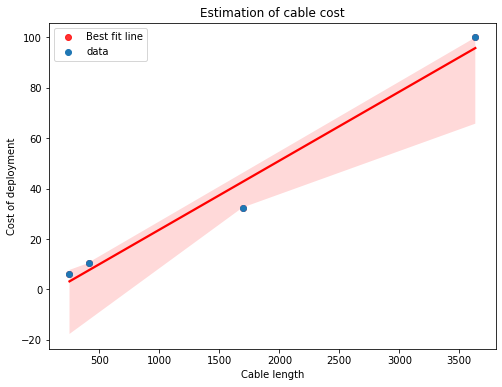

In [188]:
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(x='cable_length',y='cable_cost',data=pacific_cable_groupBy, fit_reg=True, color = 'r',label='Best fit line') 
plt.scatter(y= pacific_cable_groupBy['cable_cost'], x= pacific_cable_groupBy['cable_length'], label='data')
plt.ylabel('Cost of deployment')  
plt.xlabel('Cable length')  
ax.legend(loc='best')
plt.title("Estimation of cable cost")

In [166]:
chinese_postman_gdf['cable_cost'] = round(chinese_postman_gdf['length_from_previous'] * 0.0274 -3.6446,2)
chinese_postman_gdf = chinese_postman_gdf[chinese_postman_gdf['cable_cost'] > 5]

(-22.0, -14.0)

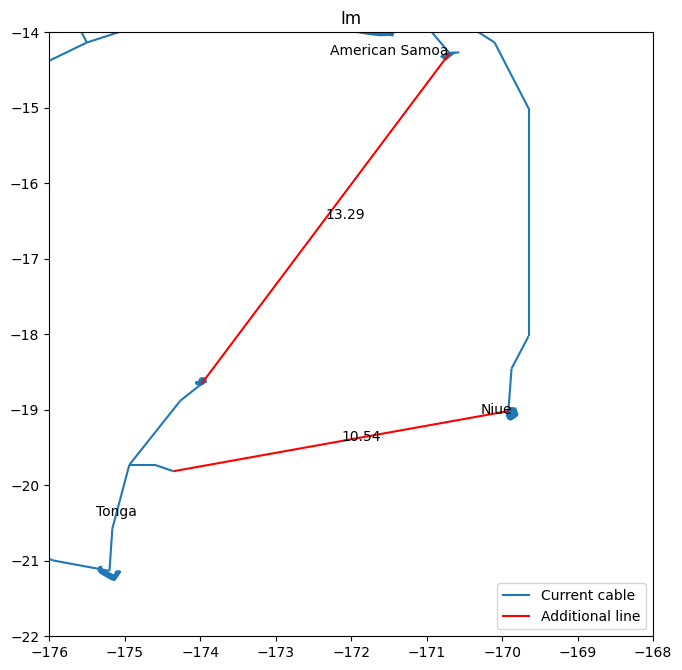

In [171]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")
world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)

pacific_cable_gps.plot(ax=ax,label = 'Current cable')

chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
chinese_postman_gdf.apply(lambda x: ax.annotate(text=x['cable_cost'], xy=x.geometry.centroid.coords[0], ha='left'), axis=1)
plt.legend(loc='lower right')
plt.title("Im")
plt.xlim([-176,-168])
plt.ylim([-22,-14])

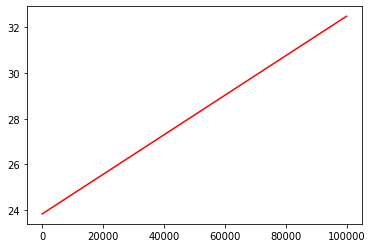

In [193]:
x = np.linspace(0,100000,50)
y = 0.00008654*x+23.83
plt.plot(x, y, '-r', label='y=2x+1')

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_21721/36457513.py:4: RuntimeWarning: divide by zero encountered in true_divide
  y1 = 23830000/25/12/x+86.54


Text(0, 0.5, 'Monthly cost')

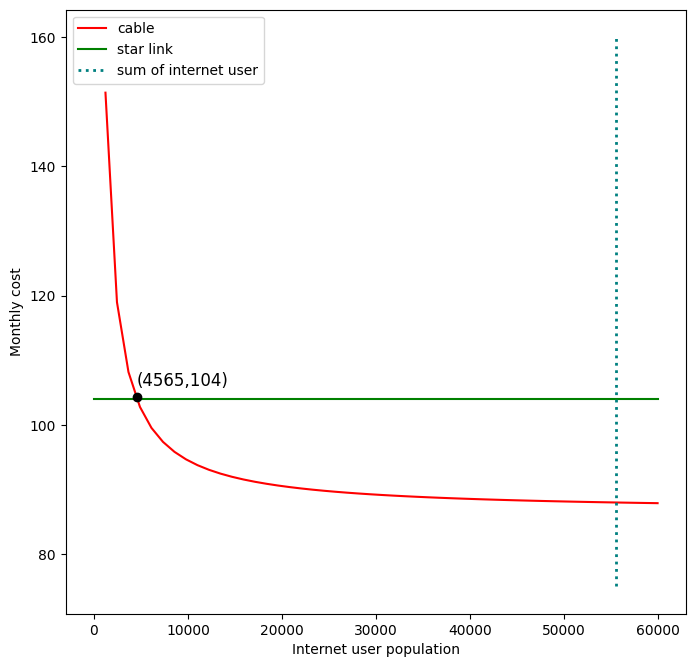

In [240]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
x1 = np.linspace(0,60000,50)
y1 = 23830000/25/12/x+86.54
ax.plot(x1, y1, '-r', label='cable')

x2 = np.linspace(0,60000,50)
y2 = 599/10/12+99+x*0
ax.plot(x2, y2, '-g', label='star link')

ax.vlines(x=55612, ymin=75, ymax=160, colors='teal', ls=':', lw=2, label='sum of internet user')

f1 = interp1d(x1, y1, kind = 'linear')
f2 = interp1d(x2, y2, kind = 'linear')
xx = np.linspace(max(x1[0], x2[0]), min(x1[-1], x2[-1]), 1000)

y1_interp = f1(xx)
y2_interp = f2(xx)

idx = np.argwhere(np.diff(np.sign(y1_interp - y2_interp))).flatten()

for index in idx:
    ax.plot(xx[index], y1_interp[index], marker = 'o', markerfacecolor = 'black', markeredgecolor = 'black')

plt.text(round(xx[index],0), round(y1_interp[index]+2,0), f'({round(xx[index],0):.0f},{round(y1_interp[index],0):.0f})', fontsize = 12)


plt.legend(loc='upper left')
plt.xlabel('Internet user population')
plt.ylabel('Monthly cost')

In [227]:
# xx[index]
y1_interp[index]

104.22951001927854